In [1]:
# imports

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

#### Loading Images

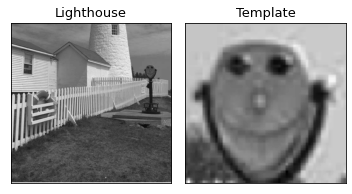

In [2]:
img = Image.open('lighthouse.png')
lighthouse = np.array(img.convert('L'), dtype = float)

img = Image.open('template.png')
template = np.array(img.convert('L'), dtype = float)

images = [ lighthouse, template ]
names = [ 'Lighthouse' , 'Template' ]

fig = plt.figure(figsize = (5,4))
rows = 1
cols = 2
for i in range(cols*rows):
    fig.add_subplot(rows,cols, i+1)
    plt.imshow(images[i], cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(names[i], fontsize=13)
    
fig.tight_layout()


## Question 1 - Edge Detection

Write a program to compute the edge map of an image.

### 1.1 - Gradient edge detectors 

In [3]:
# function to compute edge map. It takes in the image, gradient operator, gradient magnitude function and tau as arguments.

def compute_edge_map(im, grad_op_func, grad_mag_func, threshold_func):
    
    grad_X, grad_Y = grad_op_func(im)
    grad_mag = grad_mag_func(grad_X, grad_Y)
    
    threshold = threshold_func(grad_mag)
    edge_map = 1 * (grad_mag > threshold)
    
    return edge_map

### 1. Use the following gradient operators

#### (a) Centered 2-D differencing

In [4]:
def centered_differencing(image):
    
    x,y = image.shape
    grad_X, grad_Y = np.zeros((x-2, y-2)), np.zeros((x-2, y-2))
    
    kernel = np.array([-1, 0, 1]).T / 2
    
    for i in range(x-2):
        for j in range(y-2):
            grad_X[i][j] = np.dot(image[i+1, j:j+3], kernel)
            grad_Y[i][j] = np.dot(image[i:i+3, j+1], kernel)
            
    return grad_X, grad_Y

#### (b) Roberts operator

In [5]:
def roberts(image):
    
    x,y = image.shape
    grad_X, grad_Y = np.zeros((x-1, y-1)), np.zeros((x-1, y-1))
    
    kernel_x = np.array([[-1, 0],[0, 1]])
    kernel_y = np.array([[0, -1],[1, 0]])
    
    for i in range(x-1):
        for j in range(y-1):
            grad_X[i][j] = np.multiply(image[i:i+2 , j:j+2], kernel_x).sum()
            grad_Y[i][j] = np.multiply(image[i:i+2 , j:j+2], kernel_y).sum()
            
    return grad_X, grad_Y

#### (c) Prewitt operator

In [6]:
def prewitt(image):
    
    x,y = image.shape
    grad_X, grad_Y = np.zeros((x-2, y-2)), np.zeros((x-2, y-2))
    
    kernel_x = np.array([[-1, 0, 1],[-1, 0, 1],[-1, 0, 1]]) / 3
    kernel_y = np.array([[-1, -1, -1],[0, 0, 0],[1, 1, 1]]) / 3
    
    for i in range(x-2):
        for j in range(y-2):
            grad_X[i][j] = np.multiply(image[i:i+3 , j:j+3], kernel_x).sum()
            grad_Y[i][j] = np.multiply(image[i:i+3 , j:j+3], kernel_y).sum()
            
    return grad_X, grad_Y

#### (d) Sobel operator

In [7]:
def sobel(image):
    
    x,y = image.shape
    grad_X, grad_Y = np.zeros((x-2, y-2)), np.zeros((x-2, y-2))
    
    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]]) / 4
    kernel_y = np.array([[-1, -2, -1],[0, 0, 0],[1, 2, 1]]) / 4
    
    for i in range(x-2):
        for j in range(y-2):
            grad_X[i][j] = np.multiply(image[i:i+3 , j:j+3], kernel_x).sum()
            grad_Y[i][j] = np.multiply(image[i:i+3 , j:j+3], kernel_y).sum()
            
    return grad_X, grad_Y

### 2. Estimate gradient magnitude using the following definitions

#### (a) L2 norm

In [8]:
def l2_norm(grad_X, grad_Y):
    
    grad_mag = np.sqrt( grad_X ** 2, grad_Y **2 )
    return grad_mag

#### (b) L1 norm

In [9]:
def l1_norm(grad_X, grad_Y):
    
    grad_mag = np.abs(grad_X) + np.abs(grad_Y)
    return grad_mag

#### (c) Max comp

In [10]:
def max_comp(grad_X, grad_Y):
    
    abs_grad_X = np.abs(grad_X)
    abs_grad_Y = np.abs(grad_Y)
    grad_mag = np.where(abs_grad_X >= abs_grad_Y, abs_grad_X, abs_grad_Y)
    return grad_mag

### 3. Threshold the magnitude map using an empirical threshold $τ$ to find the edge map E.

In [11]:
# taking the empirical estimate as one fourth std above the mean of the image

def find_threshold(grad_mag):
    
    grad_mean = np.mean(grad_mag)
    grad_std = np.sqrt(np.var(grad_mag))
    
    return grad_mean + 0.25 * grad_std

#### Displaying all 12 edge maps

In [12]:
grad_ops = [centered_differencing, roberts, prewitt, sobel]
grad_mags = [l2_norm, l1_norm, max_comp]

edge_maps = []

for op in grad_ops:
    for mag in grad_mags:
        edge_maps.append(compute_edge_map(lighthouse, op, mag, find_threshold))

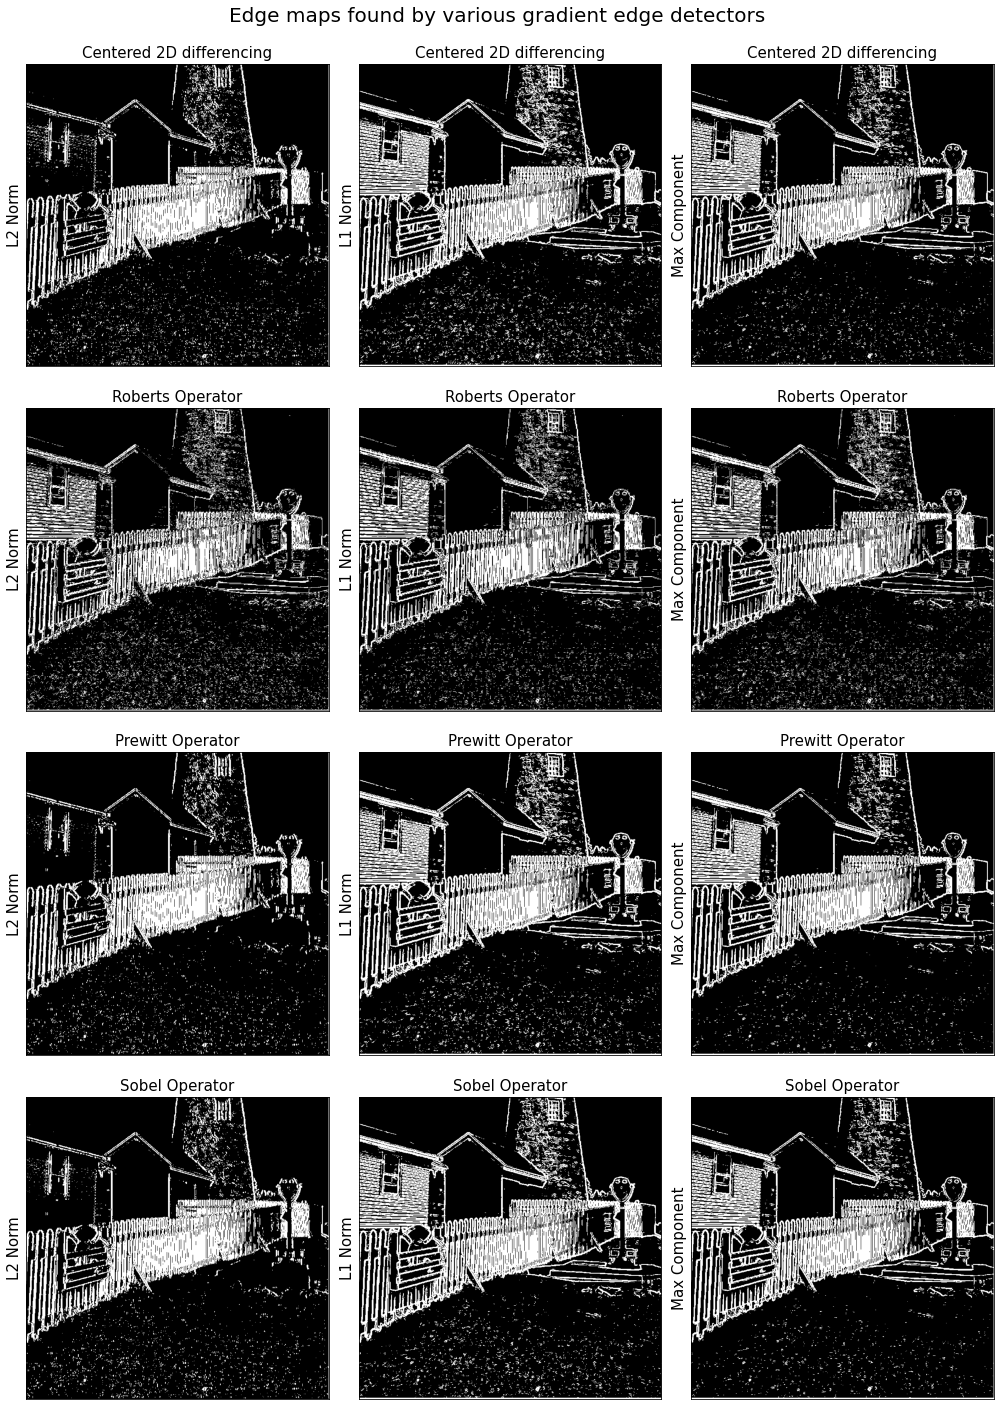

In [13]:
fig = plt.figure(figsize = (14, 20))

grad_op_names = ["Centered 2D differencing", "Roberts Operator", "Prewitt Operator", "Sobel Operator"]
grad_mag_names = ["L2 Norm", "L1 Norm", "Max Component"]

for i in range(len(edge_maps)):
    plt.subplot(4, 3, i + 1)
    plt.imshow(edge_maps[i], cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(grad_mag_names[i % 3], size = 15)
    plt.title(grad_op_names[int(i / 3)], size = 15)

plt.suptitle('Edge maps found by various gradient edge detectors \n', fontsize = 20)

fig.tight_layout()
plt.show()

### 1.2 - Laplacian edge detectors

In [14]:
# Computing laplacian using the convolution template

def compute_laplacian(image):
    
    x,y = image.shape
    laplacian = np.zeros((x-2, y-2))
    
    kernel = np.array([[0, 1, 0],[1, -4, 1],[0, 1, 0]])
    
    for i in range(x-2):
        for j in range(y-2):
            laplacian[i][j] = np.multiply(image[i:i+3 , j:j+3], kernel).sum()
            
    return laplacian

In [15]:
# Computing edge map E as an output of zero crossing detector

def compute_edge_map_using_zc(laplacian):
    x,y = laplacian.shape
    edge_map = np.zeros((x,y))
    
    ZCs = [np.array([1,-1]).T, np.array([-1,1]).T, np.array([1,0,-1]).T, np.array([-1,0,1]).T]
    
    for i in range(x-1):
        for j in range(y-1):
            windows = [laplacian[i, j:j+2], laplacian[i:i+2, j]]
            kernel = ZCs[0]
            for window in windows:
                if (np.all(np.multiply(window, kernel) > 0)):
                    edge_map[i][j] = 1

    for i in range(1, x):
        for j in range(1, y):
            windows = [laplacian[i, j-1:j+1], laplacian[i-1:i+1, j]]
            kernel = ZCs[1]
            for window in windows:
                if (np.all(np.multiply(window, kernel) > 0)):
                    edge_map[i][j] = 1
    
    for i in range(1,x-1):
        for j in range(1,y-1):
            windows = [laplacian[i, j-1:j+2], laplacian[i-1:i+2, j]]
            kernels = [ZCs[2], ZCs[3]]
            for w in windows:
                for k in kernels:
                    if(w[1] == 0 and w[0]!=0 and w[2]!=0):
                        if (np.all(np.multiply(w,k) >= 0)):
                            edge_map[i][j] = 1
                        
    return edge_map

#### Displaying the edge map computed by laplacian edge detector

In [16]:
L = compute_laplacian(lighthouse)
L_edgemap = compute_edge_map_using_zc(L)

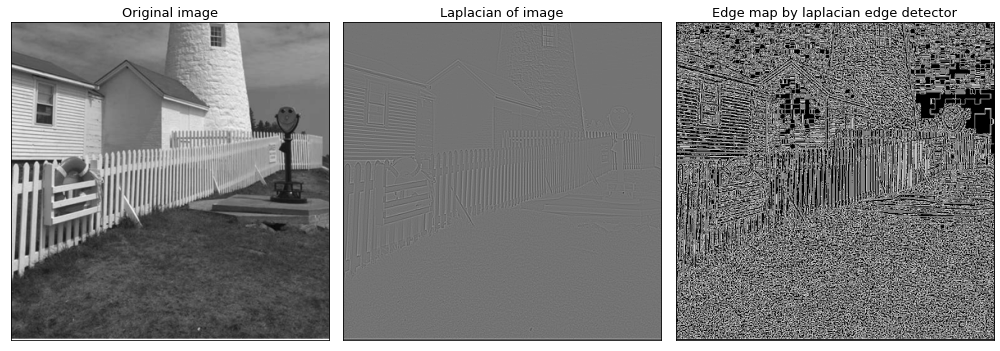

In [17]:
images = [lighthouse, L, L_edgemap]
names =['Original image', 'Laplacian of image', 'Edge map by laplacian edge detector']

fig = plt.figure(figsize = (14,7))
rows = 1
cols = 3
for i in range(cols*rows):
    fig.add_subplot(rows,cols, i+1)
    plt.imshow(images[i], cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(names[i], fontsize=13)
    
fig.tight_layout()

As we can observe from the above images, there are a lot of spurious zero crossings getting detected. This can be improved by using an LoG edge detector.

### 1.3 Laplacian of Gaussian (LoG)

In [18]:
# Digital implementation of LoG filter

LoG = np.zeros((9,9))
sigma = 5

for i in range(LoG.shape[0]):
    for j in range(LoG.shape[1]):
        
        c = (i**2 + j**2) / (sigma**2)
        LoG[i][j] = (-1 / sigma**2) * np.exp(-c/2) * (1 - c)
        
LoG = LoG - np.mean(LoG)

In [19]:
# Implementing linear convolution using DFT.

def DFT2(img):
    
    N = img.shape[1]
    def W_N_k_i(N,k,i):
        return np.exp(-2j * np.pi * k * i/ N)
    W = np.zeros((N, N), dtype = complex)
    for r in range(N):
        for c in range(N):
            W[r][c] = W_N_k_i(N, r, c)       
    return np.matmul(W, np.matmul(img, W))  
    
def IDFT2(DFT):
    
    N = DFT.shape[1]
    def W_N_k_i(N,k,i):
        return np.exp(2j * np.pi * k * i/ N)
    W_inv = np.zeros((N, N), dtype = complex)
    for r in range(N):
        for c in range(N):
            W_inv[r][c] = W_N_k_i(N, r, c)     
    return np.matmul(W_inv, np.matmul(DFT, W_inv)) / (N*N)  

def pad_image(target_size, image):
    
    N,M = image.shape
    padded = np.zeros(target_size, dtype = complex)
    padded[:N, :M] = image
            
    return padded

def linearly_convolve_using_DFT(image1, image2):
    
    N,M = image1.shape
    N1, M1 = image2.shape
    
    padded_image1 = pad_image((N+N1-1, M+M1-1), image1)
    padded_image2 = pad_image((N+N1-1, M+M1-1), image2)
    
    image_DFT = DFT2(padded_image1)
    filter_DFT = DFT2(padded_image2)
    
    res = np.multiply(image_DFT, filter_DFT)
    res_IDFT = IDFT2(res)
    
    return np.real(res_IDFT)

#### Displaying the edge map computed using LoG operator

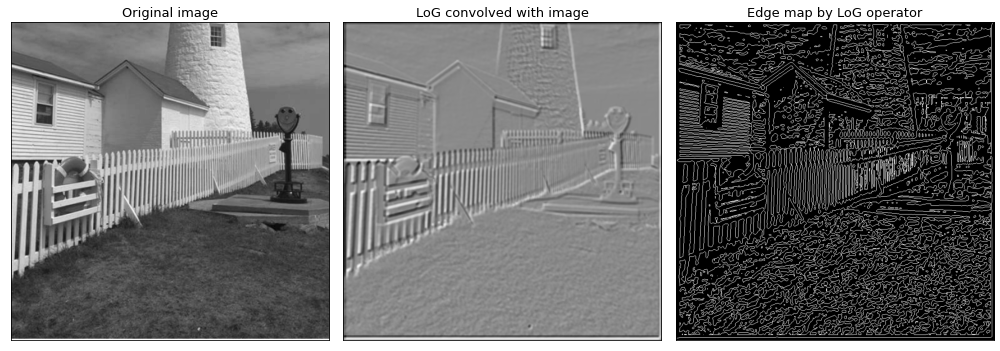

In [20]:
LoG_lighthouse = linearly_convolve_using_DFT(lighthouse, LoG)
LoG_edgemap = compute_edge_map_using_zc(LoG_lighthouse)

images = [lighthouse, LoG_lighthouse, LoG_edgemap]
names =['Original image', 'LoG convolved with image', 'Edge map by LoG operator']

fig = plt.figure(figsize = (14,7))
rows = 1
cols = 3
for i in range(cols*rows):
    fig.add_subplot(rows,cols, i+1)
    plt.imshow(images[i], cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(names[i], fontsize=13)
    
fig.tight_layout()

We observe that the edges detected by using LoG operator are very thin. They are only one pixel wide, giving a clear edge map. Also, the edges are continuous so there are no broken edges, as opposed to gradient based methods.

### Comparing robustness of gradient, laplacian and LoG operators

In [21]:
# adding noise to lighthouse image.

def awgn(image, std):
    noise = np.floor(np.random.normal(loc = 0, scale = std, size = image.shape))
    image = image + noise
    image[image>255] = 255
    return image

lighthouse_with_noise = awgn(lighthouse, 10)

In [22]:
gradient_based_without_noise = compute_edge_map(lighthouse, centered_differencing, l1_norm, find_threshold)
gradient_based_with_noise = compute_edge_map(lighthouse_with_noise, centered_differencing, l1_norm, find_threshold)

laplacian_based_without_noise = L_edgemap
laplacian_based_with_noise = compute_edge_map_using_zc(compute_laplacian(lighthouse_with_noise))

LoG_based_without_noise = LoG_edgemap
LoG_based_with_noise = compute_edge_map_using_zc(linearly_convolve_using_DFT(lighthouse_with_noise, LoG))

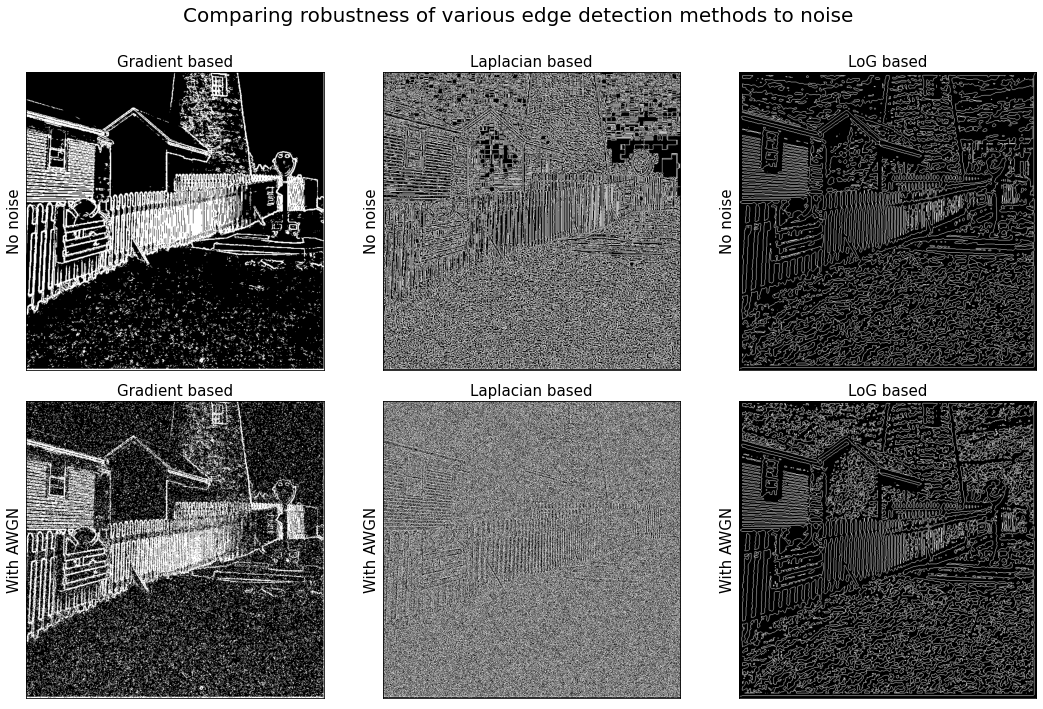

In [23]:
images = [gradient_based_without_noise, laplacian_based_without_noise, LoG_based_without_noise,
          gradient_based_with_noise, laplacian_based_with_noise, LoG_based_with_noise]

fig = plt.figure(figsize = (15,10))

method_names = ["Gradient based", "Laplacian based", "LoG based"]
noise_status = ["No noise", "With AWGN"]

for i in range(len(images)):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i], cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(noise_status[i // 3], size = 15)
    plt.title(method_names[int(i % 3)], size = 15)

plt.suptitle('Comparing robustness of various edge detection methods to noise \n', fontsize = 20)

fig.tight_layout()
plt.show()

From the above images, we can clearly observe that LoG operator based edge detection gives the best edgemap, and this method is most robust to noise.

## Question 2 - Template matching

### 1. Find the normalised cross correlation image

In [24]:
def find_normalised_cross_cor(image,template):

    m,n = template.shape
    r,c = image.shape

    normalised_cross_cor_image = np.zeros((r-m+1, c-n+1))
    energy_template = (template ** 2).sum()
    
    for i in range(normalised_cross_cor_image.shape[0]):
        for j in range(normalised_cross_cor_image.shape[1]):
            window = image[i:i+m, j:j+n]
            num = (window * template).sum()
            den = np.sqrt((window ** 2).sum() * energy_template)
            
            if den==0:
                normalised_cross_cor_image[i][j] = 0
            else:
                normalised_cross_cor_image[i][j] = num / den
    
    return normalised_cross_cor_image

In [25]:
normalised_cross_cor_image = find_normalised_cross_cor(lighthouse,template)

match_index = np.unravel_index(np.argmax(normalised_cross_cor_image, axis = None), normalised_cross_cor_image.shape)
r = match_index[0]
c = match_index[1]
template_match_from_image = lighthouse[r:r+64, c:c+64]

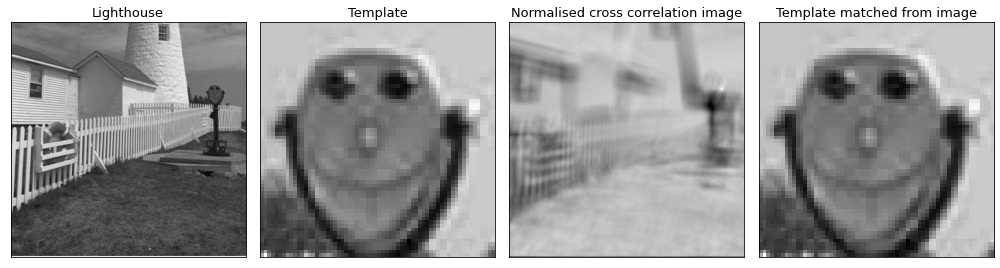

In [26]:
images = [ lighthouse, template, normalised_cross_cor_image, template_match_from_image ]
names = [ 'Lighthouse' , 'Template', 'Normalised cross correlation image', 'Template matched from image' ]

fig = plt.figure(figsize = (14,8))
rows = 1
cols = 4
for i in range(cols*rows):
    fig.add_subplot(rows,cols, i+1)
    plt.imshow(images[i], cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(names[i], fontsize=13)
    
fig.tight_layout()


### 2. What is a good threshold to detect a match

In [27]:
print('Max normalised cross correlation value is ', np.max(normalised_cross_cor_image))

Max normalised cross correlation value is  1.0


Since the max value is 1 for this image - template pair, we can choose the threshold to be 1 itself. This will enable us to detect only the perfect match. This is possible for this image because the template has been cropped from the image itself. Otherwise if the image is noisy, we must handpick a threshold.

However, a good threshold to detect a match must be slightly less than 1. We can observe the same in the noisy images in the next question.

### 3. Add Gaussian Noise and observe how the threshold changes

In [28]:
noise_sigma = [1,3,5,10]
thresholds = []
match_indices = []
template_matches = []
cross_cor_images = []
images_with_noise = []

for sigma in noise_sigma:
    
    lighthouse_with_noise = awgn(lighthouse, sigma)
    normalised_cross_cor_image = find_normalised_cross_cor(lighthouse_with_noise,template)

    match_index = np.unravel_index(np.argmax(normalised_cross_cor_image, axis = None), normalised_cross_cor_image.shape)
    r = match_index[0]
    c = match_index[1]
    threshold = np.max(normalised_cross_cor_image, axis = None)
    template_match_from_image = lighthouse_with_noise[r:r+64, c:c+64]
    
    match_indices.append([r,c])
    thresholds.append(threshold)
    images_with_noise.append(lighthouse_with_noise)
    template_matches.append(template_match_from_image)
    cross_cor_images.append(normalised_cross_cor_image)

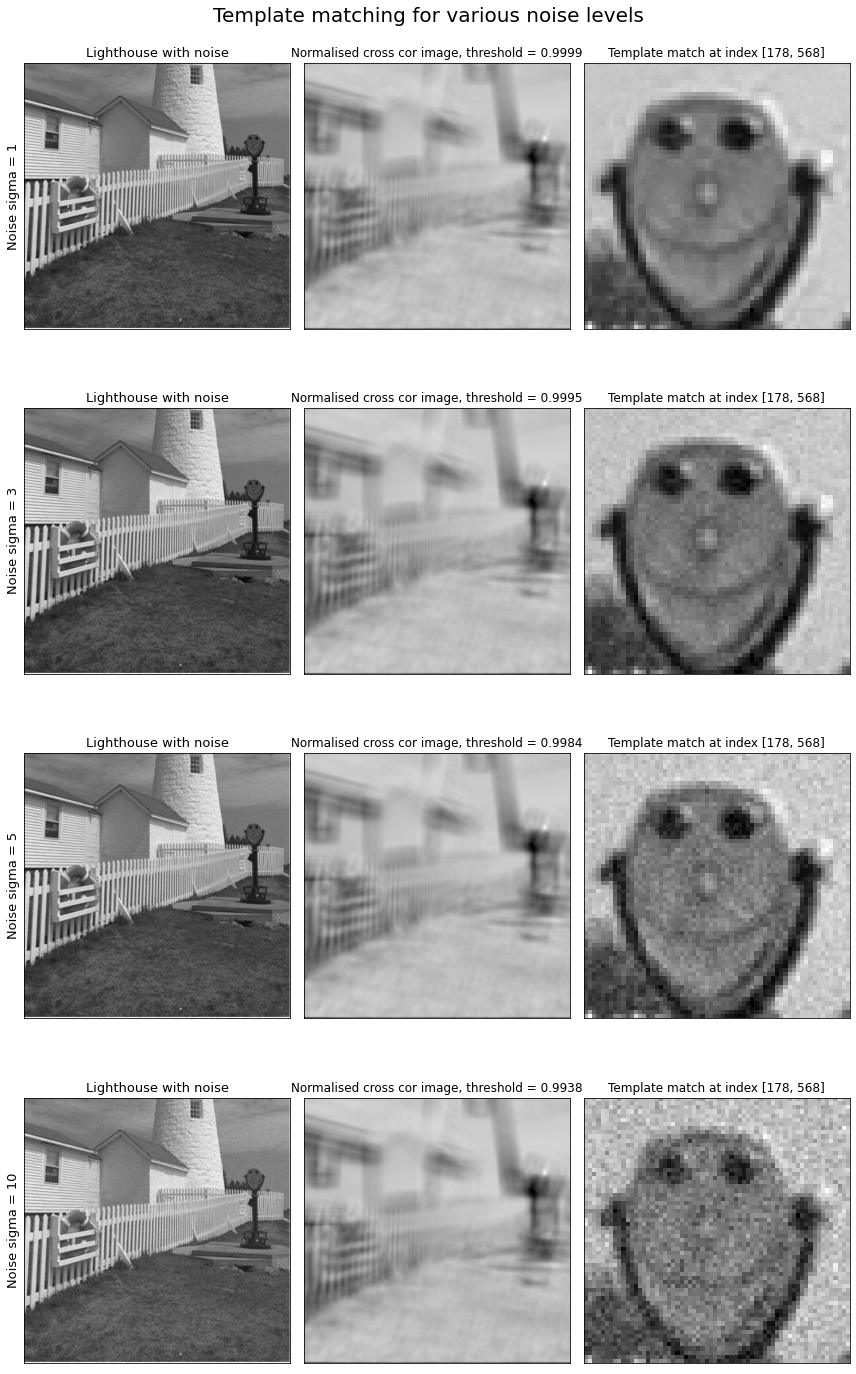

In [29]:
fig = plt.figure(figsize = (12, 20))

for i in range(12):
    plt.subplot(4, 3, i + 1)
    if (i%3==0):
        plt.imshow(images_with_noise[i//3], cmap='gray')
        plt.ylabel(f'Noise sigma = {noise_sigma[i//3]}', size = 13)
        plt.title('Lighthouse with noise', size = 13)
    if (i%3==1):
        plt.imshow(cross_cor_images[i//3], cmap='gray')
        plt.title(f'Normalised cross cor image, threshold = {thresholds[i//3]:.4f}')
    if(i%3==2):
        plt.imshow(template_matches[i//3], cmap='gray')
        plt.title(f'Template match at index {match_indices[i//3]}')
    plt.xticks([])
    plt.yticks([])

plt.suptitle('Template matching for various noise levels', fontsize = 20)

fig.tight_layout()
plt.show()

We observe that as the std of the AWGN noise increases, the threshold to detect a match keeps on decreasing. However, the template at the perfect position still gives the maximum value in the normalised cross correlation image, enabling us to detect one perfect match.

### 4. Implement rotation using rotation matrix and suitable interpolation technique

In [30]:
def rotate_image(image, angle):
    
    angle_in_rad = angle * np.pi / 180
    
    rot_matrix = np.array([[np.cos(angle_in_rad), np.sin(angle_in_rad)], [-np.sin(angle_in_rad), np.cos(angle_in_rad)]])
    
    old_side_len = image.shape[0]
    new_side_len = int(old_side_len * np.sqrt(2) * np.sin(np.pi/4 + angle_in_rad)) + 1
    
    old_center = old_side_len//2
    expected_centre = new_side_len//2
    centre = np.floor(np.matmul(rot_matrix, np.array([old_center, old_center])))
    translate = np.array([expected_centre, expected_centre] - centre)
    
    rotated_image = np.zeros((new_side_len, new_side_len))
    filled_image = np.zeros((new_side_len, new_side_len))
    
    # rotation
    
    for i in range(old_side_len):
        for j in range(old_side_len):
            m,n = np.floor(np.matmul(rot_matrix, np.array([i,j]))) + translate
            rotated_image[int(m)][int(n)] = image[i][j]
            filled_image[int(m)][int(n)] = 1
 
    # interpolation
    
    for i in range(1, new_side_len-1):
        for j in range(1, new_side_len-1):
            if filled_image[i][j] == 0:
                rotated_image[i][j] = (rotated_image[i][j-1] + rotated_image[i][j+1] + 
                                       rotated_image[i-1][j] + rotated_image[i+1][j]) // 4
    
    return rotated_image

### 5. Rotate images by 5, 10, 15 degrees and observe how threshold changes

In [31]:
angles = [5, 10, 15]
thresholds = []
match_indices = []
template_matches = []
cross_cor_images = []
images_after_rotation = []

for angle in angles:
    
    lighthouse_rotated = rotate_image(lighthouse, angle)
    normalised_cross_cor_image = find_normalised_cross_cor(lighthouse_rotated,template)

    match_index = np.unravel_index(np.argmax(normalised_cross_cor_image, axis = None), normalised_cross_cor_image.shape)
    r = match_index[0]
    c = match_index[1]
    threshold = np.max(normalised_cross_cor_image, axis = None)
    template_match_from_image = lighthouse_rotated[r:r+64, c:c+64]
    
    match_indices.append([r,c])
    thresholds.append(threshold)
    images_after_rotation.append(lighthouse_rotated)
    template_matches.append(template_match_from_image)
    cross_cor_images.append(normalised_cross_cor_image)

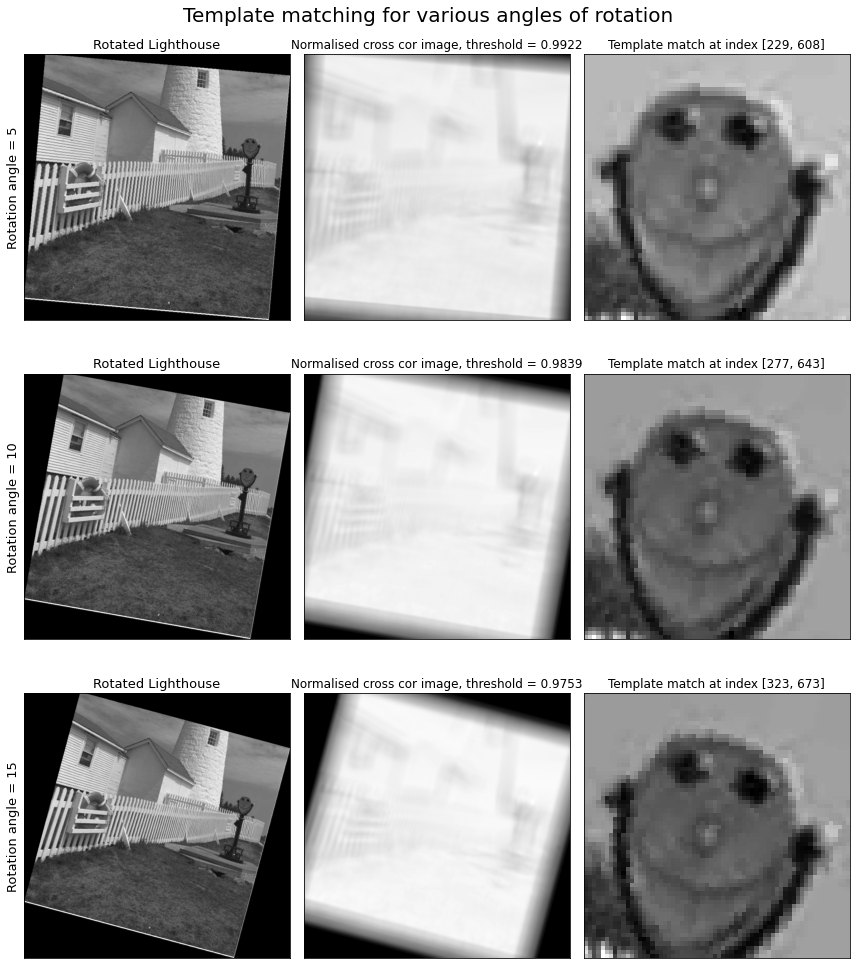

In [32]:
fig = plt.figure(figsize = (12, 14))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    if (i%3==0):
        plt.imshow(images_after_rotation[i//3], cmap='gray')
        plt.ylabel(f'Rotation angle = {angles[i//3]}', size = 13)
        plt.title('Rotated Lighthouse', size = 13)
    if (i%3==1):
        plt.imshow(cross_cor_images[i//3], cmap='gray')
        plt.title(f'Normalised cross cor image, threshold = {thresholds[i//3]:.4f}')
    if(i%3==2):
        plt.imshow(template_matches[i//3], cmap='gray')
        plt.title(f'Template match at index {match_indices[i//3]}')
    plt.xticks([])
    plt.yticks([])

plt.suptitle('Template matching for various angles of rotation', fontsize = 20)

fig.tight_layout()
plt.show()

We observe that the threshold decreases significantly as we increase rotation angle. Therefore, cross correlation based method is not very suitable for matching templates robust to rotation.